Cell 1. Импорты и стиль

In [5]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Импорт для VIF-анализа
from statsmodels.stats.outliers_influence import variance_inflation_factor

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", palette="flare")
plt.rcParams['figure.figsize'] = (6,4)

Cell 2. Загрузка данных, split и масштабирование

In [6]:
# 1) Загружаем предобработанные данные
df = pd.read_csv('../data/processed/heart_preprocessed.csv')

# 2) Разделяем на признаки и целевую
X = df.drop(columns=['output'])
y = df['output']

# 3) Train/Test split с сохранением баланса классов
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4) Масштабируем числовые признаки
num_cols = ['age','trtbps','chol','thalachh','oldpeak']
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols]  = scaler.transform(X_test[num_cols])

 Cell 3. VIF-анализ и удаление мультиколлинеарных признаков

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1) Скопируем X_train и приведём всё к float
X_vif = X_train.copy().astype(float)

# 2) Рассчитаем VIF
vif_df = pd.DataFrame({
    'feature': X_vif.columns,
    'VIF': [
        variance_inflation_factor(X_vif.values, i)
        for i in range(X_vif.shape[1])
    ]
}).sort_values('VIF', ascending=False)

print("Top features by VIF:")
display(vif_df.head(10))

# 3) Определяем и удаляем признаки с VIF > 10
drop_feats = vif_df[vif_df['VIF'] > 10]['feature'].tolist()
if drop_feats:
    print("Dropping features due to high VIF:", drop_feats)
    X_train = X_train.drop(columns=drop_feats)
    X_test  = X_test.drop(columns=drop_feats)
else:
    print("No features with VIF > 10 found.")


Top features by VIF:


,feature,VIF
20,thall_2,12.786568
21,thall_3,11.531393
14,slp_2,10.694187
13,slp_1,8.207849
5,sex_1,4.386156
19,thall_1,2.497739
10,restecg_1,2.462310
7,cp_2,2.245973
12,exng_1,2.232921
4,oldpeak,2.052861


Dropping features due to high VIF: ['thall_2', 'thall_3', 'slp_2']


Cell 4: Logistic Regression — baseline с VIF‐отфильтрованными признаками

Best LR params: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Train AUC: 0.9035224035224034
Test AUC: 0.9285714285714286


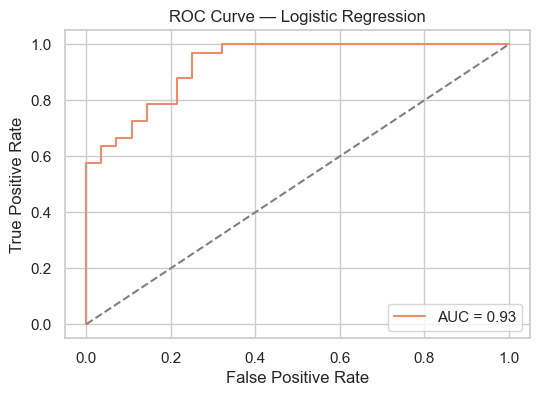

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Параметры для GridSearch
lr_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear']
}

# Обучаем
lr = GridSearchCV(LogisticRegression(), lr_params, cv=5, scoring='roc_auc')
lr.fit(X_train, y_train)

# Результаты
print("Best LR params:", lr.best_params_)
print("Train AUC:", lr.best_score_)
print("Test AUC:", lr.score(X_test, y_test))

# ROC-кривая
y_prob = lr.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.title("ROC Curve — Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


Cell 5: Random Forest

Best RF params: {'max_depth': None, 'n_estimators': 200}
Train AUC: 0.8721768971768971
Test AUC: 0.8977272727272727


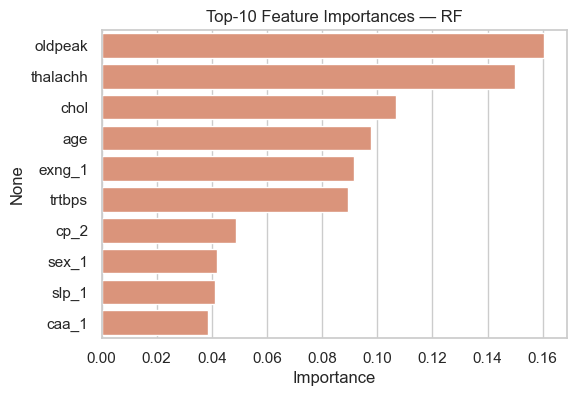

In [10]:
from sklearn.ensemble import RandomForestClassifier

# Параметры для подбора
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10]
}

rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params, 
    cv=5, 
    scoring='roc_auc'
)
rf.fit(X_train, y_train)

print("Best RF params:", rf.best_params_)
print("Train AUC:", rf.best_score_)
print("Test AUC:", rf.score(X_test, y_test))

# Визуализация топ-10 важностей
importances = rf.best_estimator_.feature_importances_
feat_imp = pd.Series(importances, index=X_train.columns).sort_values(ascending=False).head(10)

plt.figure(figsize=(6,4))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Top-10 Feature Importances — RF")
plt.xlabel("Importance")
plt.show()


Cell 6: Neural Network (PyTorch), конвертация типов


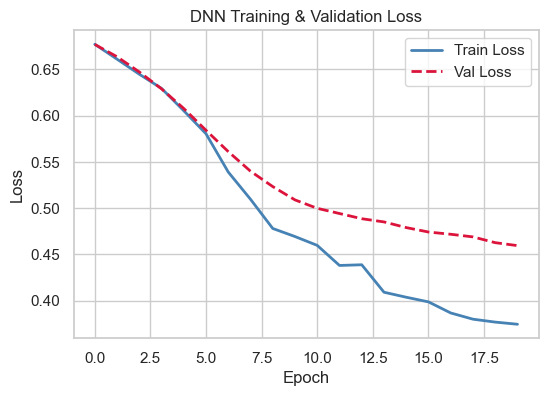

Test AUC (NeuralNetwork): 0.8712121212121213


In [22]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_auc_score, roc_curve

# 1) Приводим все колонки X_train и X_test к float32
X_train_float = X_train.astype('float32')
X_test_float  = X_test.astype('float32')

# 2) Конвертация в тензоры
Xtr = torch.from_numpy(X_train_float.values)
ytr = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
Xte = torch.from_numpy(X_test_float.values)
yte = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# 3) Создаём DataLoader
train_ds = TensorDataset(Xtr, ytr)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

# 4) Определяем сеть
class Net(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(64, 32),    nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(32, 1),     nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

model = Net(Xtr.shape[1])
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 5) Обучение
history = {'train_loss': [], 'val_loss': []}
for epoch in range(20):
    model.train(); total_loss = 0
    for xb, yb in train_dl:
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        total_loss += loss.item()
    history['train_loss'].append(total_loss / len(train_dl))

    model.eval()
    with torch.no_grad():
        val_loss = criterion(model(Xte), yte).item()
    history['val_loss'].append(val_loss)

# 6) График потерь
plt.figure()
plt.plot(
    history['train_loss'],
    label='Train Loss',
    color='steelblue',    
    linewidth=2
)
plt.plot(
    history['val_loss'],
    label='Val Loss',
    color='crimson',      
    linewidth=2,
    linestyle='--'
)
plt.title("DNN Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 7) Оценка AUC
y_pred_nn = model(Xte).detach().numpy()
print("Test AUC (NeuralNetwork):", roc_auc_score(y_test, y_pred_nn))

Cell 7. Сравнение моделей

In [23]:
from sklearn.metrics import roc_auc_score

results = {
    'LogisticRegression': roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]),
    'RandomForest':       roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]),
    'NeuralNetwork':      roc_auc_score(y_test, y_pred_nn)
}

res_df = pd.Series(results, name='Test AUC').sort_values(ascending=False)
print(res_df)


LogisticRegression    0.928571
RandomForest          0.897727
NeuralNetwork         0.871212
Name: Test AUC, dtype: float64


In [25]:
import os
os.makedirs('models', exist_ok=True)

In [26]:
import joblib
import torch

# 1) Сохраняем scaler
joblib.dump(scaler, 'models/scaler.pkl')

# 2) Сохраняем Logistic Regression
joblib.dump(lr.best_estimator_, 'models/lr_model.pkl')

# 3) Сохраняем Random Forest
joblib.dump(rf.best_estimator_, 'models/rf_model.pkl')

# 4) Сохраняем веса нейросети
torch.save(model.state_dict(), 'models/dnn_model.pt')

print("All models and scaler saved to models/ directory.")

All models and scaler saved to models/ directory.
